# **GROUP NUMBER: 6442**

# **MScFE 652 RISK MANAGEMENT**

**Group Work Project # 2**

# **Tasks**

# **Step 1**

Toy example for Baum-Welch algorithm:

Let,

S be the two states = {1,2}

O be the two observations = {A,B}

O be the observation sequence = {A,B,A}


In [ ]:
import numpy as np

def forward(obs_seq, A, B, pi):
    N = A.shape[0]
    T = len(obs_seq)
    alpha = np.zeros((T, N))

    alpha[0, :] = pi * B[:, obs_seq[0]]

    for t in range(1, T):
        for j in range(N):
            alpha[t, j] = np.dot(alpha[t-1, :], A[:, j]) * B[j, obs_seq[t]]

    return alpha

def backward(obs_seq, A, B):
    N = A.shape[0]
    T = len(obs_seq)
    beta = np.zeros((T, N))

    beta[T-1, :] = 1

    for t in range(T-2, -1, -1):
        for i in range(N):
            beta[t, i] = np.sum(A[i, :] * B[:, obs_seq[t+1]] * beta[t+1, :])

    return beta

def baum_welch(obs_seq, A, B, pi, max_iter=100, tol=1e-6):
    N = A.shape[0]
    M = B.shape[1]
    T = len(obs_seq)

    for _ in range(max_iter):
        alpha = forward(obs_seq, A, B, pi)
        beta = backward(obs_seq, A, B)

        xi = np.zeros((T-1, N, N))
        for t in range(T-1):
            denominator = np.dot(np.dot(alpha[t, :].T, A) * B[:, obs_seq[t+1]].T, beta[t+1, :])
            for i in range(N):
                numerator = alpha[t, i] * A[i, :] * B[:, obs_seq[t+1]].T * beta[t+1, :].T
                xi[t, i, :] = numerator / denominator

        gamma = np.sum(xi, axis=2)
        gamma = np.vstack((gamma, np.sum(xi[T-2, :, :], axis=0)))

        new_pi = gamma[0, :]
        new_A = np.sum(xi, axis=0) / np.sum(gamma[:-1, :], axis=0).reshape(-1, 1)
        new_B = np.zeros((N, M))

        for j in range(M):
            mask = obs_seq == j
            new_B[:, j] = np.sum(gamma[mask, :], axis=0) / np.sum(gamma, axis=0)

        if np.max(abs(A - new_A)) < tol and np.max(abs(B - new_B)) < tol and np.max(abs(pi - new_pi)) < tol:
            break

        A, B, pi = new_A, new_B, new_pi

    return A, B, pi

# Toy example
obs_seq = np.array([0, 1, 0])  # A = 0, B = 1
A = np.array([[0.7, 0.3], [0.4, 0.6]])
B = np.array([[0.5, 0.5], [0.6, 0.4]])
pi = np.array([0.6, 0.4])

A, B, pi = baum_welch(obs_seq, A, B, pi)

print("Updated A:", A)
print("Updated B:", B)
print("Updated pi:", pi)


Updated A: [[5.28642688e-10 9.99999999e-01]
 [1.00000000e+00 3.82364337e-62]]
Updated B: [[5.28642688e-10 9.99999999e-01]
 [1.00000000e+00 3.34087122e-44]]
Updated pi: [3.85651997e-20 1.00000000e+00]


# **Step 2**

In [ ]:
%%writefile dthmm.pyx
"""
Discrete-time hidden Markov model class
"""

#
# Authors: Lukas Lopatovsky, Mai 2017
#


import numpy
import random
cimport numpy
cimport cython

#cython: wraparound=False
#cython: boundscheck=False
#cython: nonecheck=False

ctypedef numpy.float64_t float_t
ctypedef numpy.int64_t int_t

cdef class DtHMM:

    """Parameters _loga, _logb, _logpi are log likelihoods to avoid underflow."""
    cdef numpy.ndarray _loga
    cdef numpy.ndarray _logb
    cdef numpy.ndarray _logpi


    @property
    def a(self):
        return numpy.exp( self._loga )

    @property
    def b(self):
        return numpy.exp( self._logb )

    @property
    def pi(self):
        return numpy.exp( self._logpi )

    @property
    def params( self ):
        return( self.a, self.b, self.pi )

    def __init__(self, A,B,Pi):
        """Initialize the DtHMM by given parameters.
        A : (n,n) ndarray
            transition probabilities matrix for (n) hidden states
        B : (n,m) ndarray
            probability matrix of (m) observation symbols being emitted by (n) hidden state
        Pi : (n) ndarray
            vector of initial probabilities
        """
        numpy.seterr( divide = 'ignore' )  #ignore warnings, when working with log(0) = -inf
        self.set_params( A,B,Pi )

    @classmethod
    def from_file( cls, path ):
        """Initialize the class by reading parameters from file"""
        return cls( *DtHMM.get_params_from_file(path) )

    @classmethod
    def random( cls, s, o ):
        """Initialize the class by random parameters of 's' hidden states and 'o' output variables"""
        return cls( *DtHMM.get_random_params( s, o ) )

    def set_params( self, A, B, Pi):
        """Set parameters as their logs to avoid underflow"""
        self._loga = numpy.log(A)
        self._logb = numpy.log(B)
        self._logpi = numpy.log(Pi)

    def set_params_from_file( self, path ):
        """Set parameters by reading them from file"""
        self.set_params( *DtHMM.get_params_from_file(path) )

    def set_params_random( self, s, o ):
        """Set parameters by random. Size of 's' hidden states and 'o' output variables"""
        self.set_params( *DtHMM.get_random_params( s, o ) )

    def save_params( self, path ):
        """Save parameters in the file given by 'path'"""
        numpy.savez( path, a=self.a, b=self.b, pi=self.pi )


    @staticmethod
    def get_params_from_file( path ):
        """Get parameters by reading them from .npz file"""
        npz = numpy.load( path )
        return ( npz['a'], npz['b'], npz['pi'] )

    @staticmethod
    def get_random_vector( s ):
        """Generate random vector of size (s), with all values summing to one"""
        vec = numpy.random.random(s)
        return vec / numpy.sum(vec)

    @staticmethod
    def get_random_params( s, o ):
        """Generate random parameters A,B and Pi, for number of hidden states (s) and output variables (o)"""

        a = numpy.empty( [s,s] )
        b = numpy.empty( [s,o] )
        pi = numpy.empty( s )

        for i in range( a.shape[0] ):
            a[i,:] = DtHMM.get_random_vector(s)
        for i in range( b.shape[0]):
            b[i,:] = DtHMM.get_random_vector(o)
        pi = DtHMM.get_random_vector(s)

        return(a,b,pi)

    def generate(self, size ):
        """Randomly generate a sequence of states and emissions from model parameters."""
        a = numpy.exp( self._loga )
        b = numpy.exp( self._logb )
        pi = numpy.exp( self._logpi )

        states = numpy.empty(size,dtype=int)
        emissions = numpy.empty(size,dtype=int)
        current_state = numpy.random.choice( pi.shape[0], 1, p= pi)
        for i in range(size):
            states[i] = current_state
            emissions[i] =  numpy.random.choice( b.shape[1],1, p = b[ current_state,:].flatten() )
            current_state = numpy.random.choice( a.shape[1],1, p = a[ current_state,:].flatten() )
        return ( states, emissions )

    def generate_data(self, size, **kargs ):
        """Generate multiple sequences of states and emissions from model parameters
           size = ( number of sequences, length of sequences  )
           **kargs:  times=True : return also equidistant sequence of times
        """
        e = numpy.empty( size, dtype=int )
        t = numpy.empty( size, dtype=int )
        s = numpy.empty( size, dtype=int )
        for i in range( size[0] ):
            s[i],e[i] = self.generate( size[1] )
            t[i] = numpy.arange(  size[1] )

        if ('times' in kargs) and kargs['times'] == True:
            return(t,s,e)

        return (s,e)

    cpdef float_t emission_estimate(self, numpy.ndarray[int_t, ndim=1] emissions ):
        """From given emission sequence calculate the likelihood estimation given model parameters"""
        return  self.log_sum( self.forward( emissions )[-1,:] )

    cpdef float_t data_estimate( self, emissions):
        """From the set of given emission sequences in the data calculate their likelihood estimation given model parameters
           Emission sequences can be given as numpy matrix or list of numpy vectors
        """

        cdef numpy.ndarray[int_t, ndim=1] row
        cdef float_t sm = 0

        for row in emissions:
            sm += self.emission_estimate( row )
        return sm

    cpdef float_t full_data_estimate( self, state_seqs, emissions ):
        """From the set of given state and emission sequences in the data calculate their likelihood estimation given model parameters
           Emission and state sequences can be given as numpy matrix or list of numpy vectors
        """
        cdef numpy.ndarray[int_t, ndim=1] e,s
        cdef float_t sm = 0

        for  s,e in zip( state_seqs, emissions ):
            sm += self.estimate( s, e )
        return sm

    cpdef float_t estimate(self, numpy.ndarray[int_t, ndim=1] states, numpy.ndarray[int_t, ndim=1] emissions):
        """Calculate the probability of state and emission sequence given the current parameters.
           Return logaritmus of probabilities.
        """
        cdef numpy.ndarray[float_t, ndim=2] loga = self._loga
        cdef numpy.ndarray[float_t, ndim=2] logb = self._logb
        cdef numpy.ndarray[float_t, ndim=1] logpi = self._logpi
        cdef int i, s, size, states_num
        cdef float_t prob  #it is log probability

        size = emissions.shape[0]
        states_num = self._loga.shape[0]

        prob = logpi[ states[0] ] + logb[ states[0], int(emissions[0]) ]

        for i in range(1,size):
            prob += loga[states[i-1],states[i]]
            prob += logb[states[i],int(emissions[i])]

        return prob


    cpdef numpy.ndarray[float_t, ndim=2] forward(self, numpy.ndarray[int_t, ndim=1] emissions):
        """From emission sequence calculate the forward variables (alpha) given model parameters.
           Return logaritmus of probabilities.
        """
        cdef numpy.ndarray[float_t, ndim=2] loga = self._loga
        cdef numpy.ndarray[float_t, ndim=2] logb = self._logb
        cdef numpy.ndarray[float_t, ndim=1] logpi = self._logpi
        cdef int i, s, size, states_num,

        size = emissions.shape[0]
        states_num = self._loga.shape[0]
        cdef numpy.ndarray[float_t, ndim=2] alpha = numpy.empty( (size,states_num), dtype=numpy.float64 )

        alpha[0,:] = logpi + logb[:, int(emissions[0]) ]
        for i in range(1,size):
            for s in range(states_num):

                alpha[i,s] = self.log_sum( alpha[i-1,:]+ loga[:,s] )

            alpha[i,:] = alpha[i,:] + logb[:, int(emissions[i]) ]

        return alpha

    cpdef numpy.ndarray[float_t, ndim=2] backward(self, numpy.ndarray[int_t, ndim=1] emissions):
        """From emission sequence calculate the backward variables beta) given model parameters.
           Return logaritmus of probabilities.
        """
        cdef numpy.ndarray[float_t, ndim=2] loga = self._loga
        cdef numpy.ndarray[float_t, ndim=2] logb = self._logb
        cdef numpy.ndarray[float_t, ndim=1] logpi = self._logpi
        cdef int i, s, size, states_num

        size = emissions.shape[0]
        states_num = self._loga.shape[0]
        cdef numpy.ndarray[float_t, ndim=2] beta = numpy.empty( (size,states_num), dtype=numpy.float64 )

        beta[-1,:] = 0  #log(1) = 0
        for i in range(size-2, -1,-1):
            for s in range(states_num):
                beta[i,s] = self.log_sum( beta[i+1,:] + loga[s,:] + logb[:, int(emissions[i+1]) ] )

        return beta

    cpdef viterbi(self, numpy.ndarray[int_t, ndim=1] e_seq):
        """
        From given emission sequence and parameters calculate the most likely state sequence
        Parameters
        ----------
        e_seq:  ndarray, int
                observation (emission) symbols sequence
        Returns
        -------
        (max_p, path) :  max_p: probability of the most likely state sequence
                         path: most likely state sequence

        """

        cdef numpy.ndarray[float_t, ndim=2] loga = self._loga
        cdef numpy.ndarray[float_t, ndim=2] logb = self._logb
        cdef numpy.ndarray[float_t, ndim=1] logpi = self._logpi
        cdef int i, s, size, states_num,
        cdef float_t max_p

        size = e_seq.shape[0]
        states_num = self._loga.shape[0]
        cdef numpy.ndarray[float_t, ndim=2] delta = numpy.empty( (size,states_num), dtype=numpy.float64 ) #numpy.zeros( (size, states_num ))
        cdef numpy.ndarray[int_t, ndim=2] psi = numpy.empty( (size,states_num), dtype=int ) #numpy.zeros( (size, states_num ))

        delta[0,:] = logpi + logb[:, int(e_seq[0]) ]
        psi[0,:] = 0
        for i in range(1,size):
            for s in range(states_num):

                delta[i,s] = delta[i-1,0] + loga[0,s]
                psi[i,s] = 0

                for r in range(1,states_num):
                    if delta[i,s] < delta[i-1,r] + loga[r,s]:
                        delta[i,s] = delta[i-1,r] + loga[r,s]
                        psi[i,s] = r

                delta[i,s] += logb[s,e_seq[i]]

        max_p = delta[-1,0]

        p = 0

        for s in range(1,states_num):
            if max_p < delta[-1,s]:
                max_p = delta[-1,s]
                p = s

        cdef numpy.ndarray[int_t, ndim=1] path = numpy.full( size, 0, dtype=int )

        for i in range(size-1,-1,-1):
            path[i] = p
            p = psi[i,p]

        return ( max_p, path )

    cpdef float_t log_sum(self, numpy.ndarray[float_t, ndim=1] vec ):
        """Count sum of items in vec, that contain logaritmic probabilities using log-sum-exp trick"""
        cdef float_t max_p              # faster for:  max_p = numpy.amax( vec )
        cdef int i                      #
        max_p = vec[0]                  #
        for i in range(1,vec.shape[0]):   #
            if max_p < vec[i] : max_p = vec[i] #

        if numpy.isinf( max_p ): return max_p  #to avoid nan in (inf-inf)

        return max_p + numpy.log( numpy.sum( numpy.exp( vec - max_p ) ) )

    cpdef float_t log_sum_elem(self, float_t x, float_t y ):
        """Count sum of two items, that contain logaritmic probabilities using log-sum-exp trick"""
        cdef float_t max_p
        if x > y: max_p = x
        else    : max_p = y

        if numpy.isinf( max_p ): return max_p  #to avoid nan in (inf-inf)

        return max_p + numpy.log( numpy.exp( x - max_p ) + numpy.exp( y - max_p ) )

    cpdef numpy.ndarray[float_t, ndim=2] single_state_prob( self, numpy.ndarray[float_t, ndim=2] alpha, numpy.ndarray[float_t, ndim=2] beta ):
        """Given forward and backward variables, count the probability for any state in any time"""
        cdef numpy.ndarray[float_t, ndim=2] gamma
        cdef float_t max_p, log_sum

        gamma = alpha + beta
        for i in range(gamma.shape[0]):
            gamma[i] -= self.log_sum(gamma[i])

        return gamma

    cpdef numpy.ndarray[float_t, ndim=3] double_state_prob( self, numpy.ndarray[float_t, ndim=2] alpha,
                                                                  numpy.ndarray[float_t, ndim=2] beta,
                                                                  numpy.ndarray[int_t, ndim=1  ] emissions):
        """Given forward and backward variables, count the probability for transition from any state x to any state y in any time"""
        cdef numpy.ndarray[float_t, ndim=3] ksi = numpy.empty( (alpha.shape[0]-1,alpha.shape[1],alpha.shape[1]) , dtype=numpy.float64 )
        cdef numpy.ndarray[float_t, ndim=2] loga = self._loga  #Such declaration make it cca 10% faster
        cdef numpy.ndarray[float_t, ndim=2] logb = self._logb

        for t in range( ksi.shape[0]):
            for i in range( ksi.shape[1]):
                for j in range( ksi.shape[2]):
                    ksi[t,i,j] = alpha[t,i] + loga[i,j] + logb[j, emissions[t+1] ] + beta[t+1,j]
            ksi[t,:,:] -= self.log_sum( ksi[t,:,:].flatten()  )

        return ksi  #Note: actually for use in Baum welch algorithm, it wouldn't need to store whole array.

    cdef _seqs_check( self, seqs, num , error_string ):

        mx = 0
        for s in seqs:
            mx = max( mx, numpy.max(s) )
        if mx >= num:
                raise ValueError( error_string, mx+1," vs ", num )

    cpdef maximum_likelihood_estimation( self, s_seqs, e_seqs ):
        """
        Given dataset of state and emission sequences estimate the most likely parameters.
        Parameters
        ----------
        s_seqs : 2D ndarray or list of ndarrays, int
                 hidden states sequences
        e_seqs:  2D ndarray or list of ndarrays, int
                 observation (emission) symbols sequences
        """

        self._seqs_check( s_seqs,  self._logb.shape[0], "Data has more hidden states than model. " )
        self._seqs_check( e_seqs,  self._logb.shape[1], "Data has more observation symbols than model. " )


        cdef numpy.ndarray[int_t, ndim=1] sum_0, sum_last, sum_all, ss, es
        cdef numpy.ndarray[int_t, ndim=2] sum_move, sum_emit

        cdef int s_num = self._logb.shape[0]  #number of states
        cdef int o_num = self._logb.shape[1]  #number of possible observation symbols (emissions)
        cdef int seq_num,it


        if isinstance(s_seqs, list): seq_num = len(s_seqs)  #list of numpy vectors
        else: seq_num = s_seqs.shape[0]

        sum_0 =    numpy.zeros  ( s_num , dtype=numpy.int64)
        sum_last = numpy.zeros  ( s_num , dtype=numpy.int64)
        sum_all =  numpy.zeros  ( s_num , dtype=numpy.int64)
        sum_move = numpy.zeros( (s_num,s_num ) , dtype=numpy.int64)
        sum_emit = numpy.zeros( (s_num,o_num ) , dtype=numpy.int64)

        for ss,es in zip( s_seqs, e_seqs):

            sum_0[ss[0]]+= 1
            sum_all[ss[0]]+= 1
            sum_emit[ ss[0], es[0] ]+=1
            sum_last[ ss[-1] ]+=1

            for it in range(1, ss.size ):

                sum_all[ ss[it] ]+=1
                sum_move[ ss[it-1], ss[it] ]+=1
                sum_emit[ ss[it], es[it] ]+=1

        self._logpi = numpy.log( sum_0 / seq_num )
        self._loga  = numpy.log( (sum_move.T / (sum_all-sum_last ) ).T )
        self._logb  = numpy.log( (sum_emit.T / sum_all).T )

    cpdef states_confidence( self, e_seq ):
        """Given emission sequence, return probabilities that emission is generated by a state, for every time and every state."""
        return self.single_state_prob( self.forward ( e_seq ), self.backward( e_seq ) )

    def baum_welch( self, e_seqs, iterations = 10, **kvargs ):
        """
        Estimate parameters by Baum-Welch algorithm

        Parameters
        ----------
        e_seqs:  2D ndarray or list of ndarrays
              observation (emission) symbols sequences
        iterations: Optional[int]
                    number of algorithm iterations
        **est :  boolean
                 if True return the vector of estimations for every iteration
                 default: False
        Returns
        -------
        graph : (iterations + 1) ndarray
                if **est== True
                None otherwise
        References
        ----------
        .. [1] Rabiner, L. R.: A tutorial on hidden Markov models and selected applic-
               ations in speech recognition. Proceedings of the IEEE, volume 77, no. 2,
               1989: pp. 257–286.
        """
        if 'est' in kvargs:
            if kvargs['est'] == True:
                return self._baum_welch( e_seqs, True, iterations )

        self._baum_welch( e_seqs, False, iterations )

    cpdef _baum_welch(self, data, int est, iterations = 10 ):
        """
        Estimate parameters by Baum-Welch algorithm.
        Called internally by baum_welch function.
        """

        self._seqs_check( data,  self._logb.shape[1], "Data has more observation symbols than model. " )

        cdef numpy.ndarray[float_t, ndim=1] gamma_sum, pi_sum, gamma_full_sum, gamma_part_sum
        cdef numpy.ndarray[int_t, ndim=1] row
        cdef numpy.ndarray[float_t, ndim=2] alpha, beta, gamma, ksi_sum, obs_sum
        cdef numpy.ndarray[float_t, ndim=3] ksi

        cdef int s_num = self._logb.shape[0]  #number of states
        cdef int o_num = self._logb.shape[1]  #number of possible observation symbols (emissions)
        cdef int i,j,t,it, seq_num

        if isinstance(data, list): seq_num = len(data)  #list of numpy vectors
        else: seq_num = data.shape[0]                   #numpy matrix


        if est:
            graph = numpy.zeros(iterations+1)

        for it in range( iterations ):



            print("iteration ", it+1, "/", iterations )

            ksi_sum = numpy.full( ( s_num, s_num ) , numpy.log(0), dtype=numpy.float64 )
            obs_sum = numpy.full( ( s_num, o_num ) , numpy.log(0), dtype=numpy.float64 )  #numpy can samewhat handle infinities or at least exp(log(0)) = 0
            pi_sum  = numpy.full(  s_num , numpy.log(0), dtype=numpy.float64 )
            gamma_part_sum  = numpy.full(  s_num , numpy.log(0), dtype=numpy.float64 )
            gamma_full_sum  = numpy.full(  s_num , numpy.log(0), dtype=numpy.float64 )
            gamma_sum = numpy.empty( s_num , dtype=numpy.float64 )


            for row in data:

                alpha = self.forward ( row )
                beta =  self.backward( row )

                gamma = self.single_state_prob( alpha, beta )
                ksi = self.double_state_prob( alpha, beta, row )

                if est:
                    graph[it] += self.log_sum( alpha[-1,:] )


                #expected number of being in state i in time 0
                for i in range( s_num ):
                    pi_sum[i] = self.log_sum_elem( pi_sum[i], gamma[0,i] )


                #expected number of transition from i to j
                for i in range( s_num ):
                    for j in range( s_num ):
                        ksi_sum[i,j] = self.log_sum_elem( ksi_sum[i,j], self.log_sum( ksi[:,i,j] ) )

                #expected number of transition from state i
                for i in range( s_num ):
                    gamma_sum[i] = self.log_sum( gamma[:-1,i] )

                #sum gamma to the whole dataset array
                for i in range ( s_num ):
                    gamma_part_sum[i] = self.log_sum_elem( gamma_part_sum[i], gamma_sum[i] )

                #expected number of visiting state i and observing symbol v
                for t in range( row.shape[0] ):
                    for i in range( s_num ):
                        obs_sum[i,row[t]] = self.log_sum_elem( obs_sum[i,row[t]], gamma[t,i] )

                #expected number of visiting state i
                for i in range( s_num ):  #full length sum
                    gamma_sum[i] = self.log_sum_elem( gamma_sum[i], gamma[-1,i]  )

                #sum gamma to the whole dataset array
                for i in range ( s_num ):
                    gamma_full_sum[i] = self.log_sum_elem( gamma_full_sum[i], gamma_sum[i] )

            #Update parameters:

            #initial probabilities estimation
            self._logpi = pi_sum - numpy.log( seq_num )  #average
            #transition matrix estimation
            self._loga = (ksi_sum.T - gamma_part_sum).T
            #observetion symbol emission probabilities estimation
            self._logb = (obs_sum.T - gamma_full_sum).T

        if est:
            graph[iterations] = self.data_estimate( data)
            return graph


    def meow(self):
        """Make the DtHMM to meow"""
        print('meow!')


def main():
    my_hmm = DtHMM()
    my_hmm.meow()

if __name__ == "__main__":
    main()

Overwriting dthmm.pyx


In [ ]:
%%writefile setup.py
from setuptools import setup, Extension
from Cython.Build import cythonize
import numpy

extensions = [
    Extension(
        "dthmm",
        ["dthmm.pyx"],
        include_dirs=[numpy.get_include()],
        define_macros=[("NPY_NO_DEPRECATED_API", "NPY_1_7_API_VERSION")],
    )
]

setup(
    name="dthmm",
    ext_modules=cythonize(extensions),
)

Overwriting setup.py


In [ ]:
%%writefile art.py
import dthmm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy
import scipy.linalg

import pandas as pd
from IPython.display import display



def print_parameters( hmm ):

    print("Initial probabilities (π) :")
    display( pd.DataFrame(hmm.pi) )

    if hasattr(hmm, 'a'):
        print("Transition probabilities matrix (A):")
        display( pd.DataFrame(hmm.a) )

    else:
        print("Transition rate matrix (Q):")
        display( pd.DataFrame(hmm.q) )
        print("Transition probabilities for one time unit :")
        display( pd.DataFrame(  scipy.linalg.expm(hmm.q) ) )

    print("Emission probabilities matrix (B):")
    display( pd.DataFrame(hmm.b) )

def plot_hmm( s_seq, e_seq, **kargs ):

    n = e_seq.shape[0]

    if 'time' in kargs:
        X = kargs['time']
    else:
        X = numpy.arange(n)
    Y0 = numpy.zeros(n)
    Y1 = numpy.ones(n)

    fig, ax = plt.subplots()

    ax.set_aspect('equal')

    plt.xlim( numpy.amin(X)-1, numpy.amax(X)+1 ), plt.xticks([])
    plt.ylim(-2,3), plt.yticks([])

    e_num = numpy.amax( e_seq )+1
    s_num = numpy.amax( s_seq )+1

    last_time = X[0] - 1;

    for (x,y,c) in zip(X,Y1,s_seq):
        plt.annotate( c , xy=(x, y), xycoords='data', xytext=(-5, -5), textcoords='offset points', fontsize=16 )
        ax.add_artist(plt.Circle((x, y), 0.3, color=cm.gnuplot( c/s_num ), alpha=0.4))
        ax.arrow( last_time +0.3, y, -0.7+(x-last_time), 0, head_width=0.35, head_length=0.1, fc='k', ec='k')
        ax.arrow(x, y-0.3, 0, -0.3, head_width=0.35, head_length=0.1, fc='k', ec='k')
        last_time = x

    for (x,y,c) in zip(X,Y0,e_seq):
        ax.add_artist(plt.Circle((x, y), 0.3, color=cm.gnuplot( 0.9*c/e_num + 0.1), alpha=0.7))
        plt.annotate( c , xy=(x, y), xycoords='data', xytext=(-5, -5), textcoords='offset points', fontsize=16 )

    plt.show()


Overwriting art.py


In [1]:
!pip install fredapi
!pip install hmms
!pip install cython
!python setup.py build_ext --inplace

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.8/524.8 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.7 MB/s eta 0:00:00
  Created wheel for hmms: filename=hmms-0.2.3-cp310-cp310-linux_x86_64.whl size=2152620 sha256=3ed3812969f3b3998a143671c4121e80d60a7e5fffe5e0350c374bae32c8abb6
  Stored in directory: /root/.cache/pip/wheels/aa/6f/a4/1dbae244341f24881dce9465aa533729d2ae870cff3866070f
Successfully built hmms
python3: can't open file '/content/setup.py': [Errno 2] No such file or directory


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hmms
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection

import dthmm as hmms
from art import print_parameters, plot_hmm

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from fredapi import Fred
# FRED API key
fred_key = "f9c22fca078ece81a7a2ac6fba29b8a9";
# Initiates a session with the FRED datacenter to recieve datasets
fred = Fred(api_key=fred_key);
# Retrieve data from FRED API
fred_data = pd.DataFrame(fred.get_series('WTISPLC'), columns=['WTISPLC'])
fred_data.head()

,WTISPLC
1946-01-01,1.17
1946-02-01,1.17
1946-03-01,1.17
1946-04-01,1.27
1946-05-01,1.27


<Axes: >

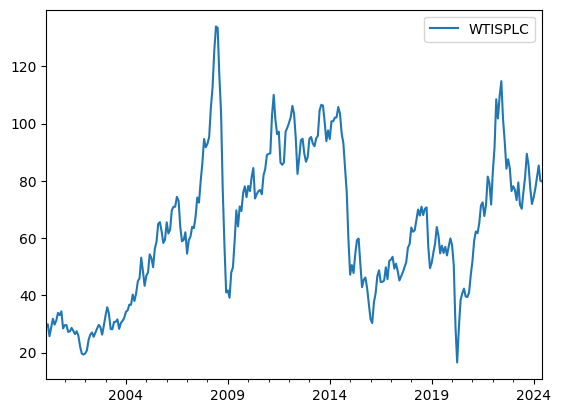

In [ ]:
data_2000 = fred_data[fred_data.index > '2000-01-01']
data_2000.plot()

iteration  1 / 100
iteration  2 / 100
iteration  3 / 100
iteration  4 / 100
iteration  5 / 100
iteration  6 / 100
iteration  7 / 100
iteration  8 / 100
iteration  9 / 100
iteration  10 / 100
iteration  11 / 100
iteration  12 / 100
iteration  13 / 100
iteration  14 / 100
iteration  15 / 100
iteration  16 / 100
iteration  17 / 100
iteration  18 / 100
iteration  19 / 100
iteration  20 / 100
iteration  21 / 100
iteration  22 / 100
iteration  23 / 100
iteration  24 / 100
iteration  25 / 100
iteration  26 / 100
iteration  27 / 100
iteration  28 / 100
iteration  29 / 100
iteration  30 / 100
iteration  31 / 100
iteration  32 / 100
iteration  33 / 100
iteration  34 / 100
iteration  35 / 100
iteration  36 / 100
iteration  37 / 100
iteration  38 / 100
iteration  39 / 100
iteration  40 / 100
iteration  41 / 100
iteration  42 / 100
iteration  43 / 100
iteration  44 / 100
iteration  45 / 100
iteration  46 / 100
iteration  47 / 100
iteration  48 / 100
iteration  49 / 100
iteration  50 / 100
iteration

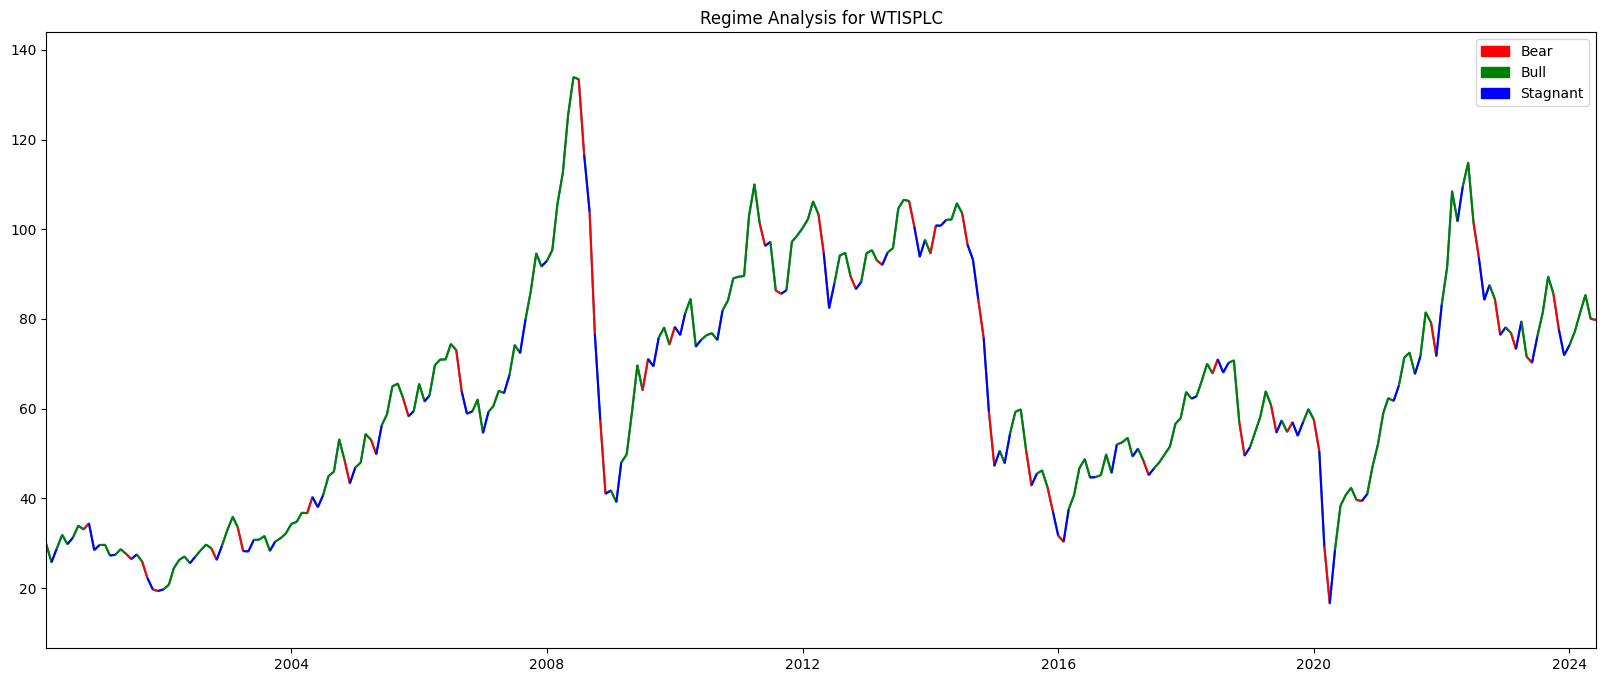

In [ ]:


price = data_2000['WTISPLC'];
# The first value is NaN as there is not a previous month to compare with
price_diff = price.diff()[1:];

# Replacing the change with 1 if positive, else 0
e_seq = np.array(price_diff.apply(lambda x: 1 if x > 0 else 0).values);

# Initialize a discrete-time Hidden Markov Model (HMM) with random parameters
# The model is configured with 3 hidden states and 2 observation symbols.
dhmm_r = hmms.DtHMM.random(3 , 2);

# Ensure e_seq is a 2D array (n_samples, 1)
e_seq = e_seq.reshape(1, -1)  # Single sequence with length n_samples

# Train the Hidden Markov Model (HMM) using the Baum-Welch algorithm with a maximum of 100 iterations
dhmm_r.baum_welch(e_seq, 100); # 100 iterations

# Apply the Viterbi algorithm to find the most probable sequence of hidden states
( log_prob, s_seq ) =  dhmm_r.viterbi(np.concatenate(e_seq).ravel());

# Add price
price_plot = pd.DataFrame(price[1:], index=price[1:].index)

# Add a column representing the regime
price_plot['Regime'] = s_seq

# Add a column representing the increase or decrease in price
price_plot['diff'] = price_diff

# Get means of all assigned states
means = price_plot.groupby(['Regime'])['diff'].mean()

# Obtain lists to sort regimes by their mean price differences
lst_1 = means.index.tolist()
lst_2 = means.sort_values().index.tolist()

# Create a mapping from sorted regimes to original regimes
map_regimes = dict(zip(lst_2, lst_1))

# Apply the mapping to the 'Regime' column
price_plot['Regime'] = price_plot['Regime'].map(map_regimes)

# Plotting
fig, ax1 = plt.subplots(figsize=(20, 8))
ax1.plot(price_plot['WTISPLC'])

# Make 0 (Bear) - red, 1 (Stagnant) - blue, 2 (Bull) - green
cmap = ListedColormap(['r', 'b', 'g'], 'indexed')
norm = BoundaryNorm(range(3 + 1), cmap.N)

# Convert index to matplotlib date format
inxval = mdates.date2num(price_plot['WTISPLC'].index.to_pydatetime())
points = np.array([inxval, price_plot['WTISPLC']]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create a line collection with the segments and add it to the plot
lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(price_plot['Regime'])
plt.gca().add_collection(lc)

# Set x and y limits
plt.xlim(price_plot['WTISPLC'].index.min(), price_plot['WTISPLC'].index.max())
plt.ylim(price_plot['WTISPLC'].min() - 10, price_plot['WTISPLC'].max() + 10)  # Added padding

# Create legend patches
r_patch = mpatches.Patch(color='red', label='Bear')
g_patch = mpatches.Patch(color='green', label='Bull')
b_patch = mpatches.Patch(color='blue', label='Stagnant')

# Add legend
plt.legend(handles=[r_patch, g_patch, b_patch])

# Add title
plt.title(f'Regime Analysis for WTISPLC')

plt.show()

The above plot shows the period of bear regimes with red color, bull regimes with green color and stagnant regimes with blue color.

# **Step 9**

In order to implement the minimal working example of a hill climb search for learning Bayesian Network, the provided example in the thesis is followed on the combined data of  macroeconomic and financial datasets that we have and the pgmpy library is used.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import statsmodels.api as sm
from scipy import stats
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

In [3]:
from fredapi import Fred
# FRED API key
fred_key = "f9c22fca078ece81a7a2ac6fba29b8a9";
# Initiates a session with the FRED datacenter to recieve datasets
fred = Fred(api_key=fred_key);
# Retrieve data from FRED API
fred_data = pd.DataFrame(fred.get_series('WTISPLC'), columns=['WTISPLC'])

In [4]:
datasets_fred = [
'WTISPLC',    # Spot Crude Oil Price: West Texas Intermediate (WTI) (WTISPLC)
'CPIENGSL', # Consumer Price Index for All Urban Consumers: Energy in U.S. City Average
'CAPG211S', # Industrial Capacity: Mining: Oil and Gas Extraction (NAICS = 211)
'CAPUTLG211S', #  Capacity Utilization: Mining: Oil and Gas Extraction (NAICS = 211)
'IPG211S', # Industrial Production Index: Mining: Oil and Gas Extraction (NAICS = 211)
'INDPRO', #  Industrial Production: Total Index
'IPN213111N', # Industrial Production: Mining: Drilling Oil and Gas Wells
'PCU211211', # Producer Price Index: Mining: Oil and Gas Extraction (NAICS = 211)
                ];

data_frames = []; # List of dataframes to be concatenated

# Adding FRED datasets
for series_id in datasets_fred:
  # Get series from FRED
  df = pd.DataFrame(fred.get_series(series_id), columns=[series_id]);
  data_frames.append(df);

macro_data = pd.concat(data_frames, axis=1)
#macro_data = macro_data[macro_data.index > '2000-01-01']

In [5]:
financial_datasets_fred = [
'DEXCAUS', #Canadian dollar to US dollar exchange rate
'VIXCLS', #CBOE Volatility Index
'DCOILWTICO', #WTI Crude oil futures
'DCOILBRENTEU', #Brent crude oil futures
'SP500', #S&P500 Index
];

finan_data_frames = []; # List of dataframes to be concatenated

# Adding FRED datasets
for series_id in financial_datasets_fred:
  # Get series from FRED
  df = pd.DataFrame(fred.get_series(series_id), columns=[series_id]);
  finan_data_frames.append(df);

fin_data = pd.concat(finan_data_frames, axis=1)
#fin_data = data_merge[fin_data.index > '2000-01-01']

In [12]:
data = pd.merge(macro_data, fin_data, left_index=True, right_index=True)
data.head()

,WTISPLC,CPIENGSL,CAPG211S,CAPUTLG211S,IPG211S,INDPRO,IPN213111N,PCU211211,DEXCAUS,VIXCLS,DCOILWTICO,DCOILBRENTEU,SP500
1971-02-01,3.56,26.2,NaN,NaN,NaN,37.4386,NaN,NaN,1.0076,NaN,NaN,NaN,NaN
1971-03-01,3.56,26.2,NaN,NaN,NaN,37.3980,NaN,NaN,1.0076,NaN,NaN,NaN,NaN
1971-04-01,3.56,26.1,NaN,NaN,NaN,37.6080,NaN,NaN,1.0076,NaN,NaN,NaN,NaN
1971-06-01,3.56,26.3,NaN,NaN,NaN,37.9574,NaN,NaN,1.0126,NaN,NaN,NaN,NaN
1971-07-01,3.56,26.3,NaN,NaN,NaN,37.8472,NaN,NaN,1.0232,NaN,NaN,NaN,NaN


In [14]:
!pip install pgmpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manyl

  0%|          | 0/1000000 [00:00<?, ?it/s]

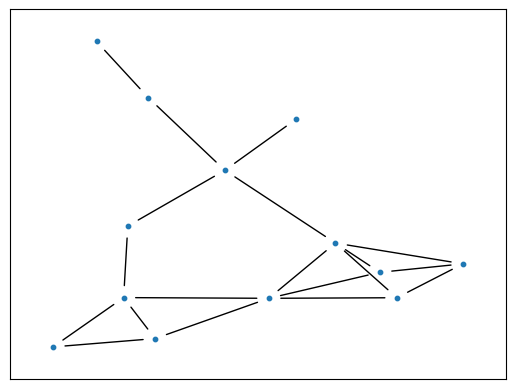

<Figure size 2000x1000 with 0 Axes>

In [19]:
import pandas as pd
from pgmpy.models import BayesianModel
from pgmpy.estimators import HillClimbSearch, BayesianEstimator, K2Score
import networkx as nx
import matplotlib.pyplot as plt
from fredapi import Fred

# Drop rows with missing values
data.dropna(inplace=True)

# Discretize the data for HMM
combined_data_diff = data.diff().dropna()
discretized_data = combined_data_diff.applymap(lambda x: 1 if x > 0 else 0)

# Load the discretized training data
train_data = discretized_data

# Hill Climbing Search Implementation
hc = HillClimbSearch(train_data)

# Expert knowledge model initialization
expert = BayesianModel()
expert.add_nodes_from(datasets_fred + financial_datasets_fred)
expert.add_edges_from([
    ('WTISPLC', 'DEXCAUS'),      # Example edges, replace with actual expert knowledge edges
    ('CPIENGSL', 'VIXCLS'),
    ('CAPG211S', 'DCOILWTICO'),
    ('CAPUTLG211S', 'SP500'),
    ('IPG211S', 'DCOILBRENTEU'),
    ('INDPRO', 'SP500'),
    ('IPN213111N', 'WTISPLC'),
    ('PCU211211', 'WTISPLC'),
])

# Perform Hill Climbing search and create a BayesianModel from the estimated DAG
model_structure = hc.estimate(scoring_method=K2Score(train_data)) # Estimate the DAG structure
model = BayesianModel(model_structure.edges()) # Create a BayesianModel from the DAG

# Fit the model to training data
model.fit(train_data, state_names=dict(map(lambda e: (e, [0, 1, 2]), datasets_fred + financial_datasets_fred)), estimator=BayesianEstimator, prior_type="K2")

# Visualize the learned Bayesian Network
G = nx.Graph()
G.add_edges_from(model.edges())
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=10)
nx.draw_networkx_edges(G, pos, arrows=True)
plt.figure(5, figsize=(20, 10))
plt.show()


In the above plot, the nodes represent the variables of the dataset and edges represent the dependencies between them. Here, the nodes with many connections can be the key variables.
Now, the model has been fitted using the hill climb search and inferences can be made using forecasts as evidence.
